In [1]:
from __future__ import print_function
import tensorflow as tf
import numpy as np
from read_dataset import generator
import os
tr_path = os.getcwd() + "\\..\\data\\sample_data\\train\\"

In [2]:
for batch, delay in generator(tr_path):
    x = batch
    y = delay
    break

[[None 10000 10000 10000 None None None None None None None None None
  None]
 [10000 None 10000 None None None None 10000 None None None None None
  None]
 [10000 10000 None None None 25000 None None None None None None None
  None]
 [10000 None None None 25000 None None None 25000 None None None None
  None]
 [None None None 25000 None 25000 10000 None None None None None None
  None]
 [None None 25000 None 25000 None None None None None None None 10000
  10000]
 [None None None None 10000 None None 10000 None None None None None None]
 [None 10000 None None None None 10000 None None None 25000 None None
  None]
 [None None None 25000 None None None None None 10000 None 10000 None
  None]
 [None None None None None None None None 10000 None 10000 None 10000
  None]
 [None None None None None None None 25000 None 10000 None 10000 None
  10000]
 [None None None None None None None None 10000 None 10000 None 10000
  None]
 [None None None None None 10000 None None None 10000 None 10000 

In [3]:
import configparser
config = configparser.ConfigParser()
config._interpolation = configparser.ExtendedInterpolation()
config.read('../code/config.ini')

['../code/config.ini']

In [11]:
len(x['link_capacity'])
xx = tf.expand_dims(x['link_capacity'], axis=1)
xx.shape

TensorShape([42, 1])

### Explanation of some of the matrix manipulation done inside the model ###

In [58]:
# stack demo
a = np.array([[1,2,3]])
b = np.array([[1,2,3]])
c = np.array([[1,2,3]])

print(np.stack((a,b,c),axis = 0))
print("\n\n")
shape = tf.stack([
    x['n_links'],
    int(config['HYPERPARAMETERS']['link_state_dim']) - 1
], axis=0)

print(shape,"\n")
link_expanded = tf.expand_dims(x['link_capacity'],axis=1)
# print(link_expanded.shape,link_expanded)

# need to cast the capacity to floats
x['link_capacity'] = tf.cast(x['link_capacity'],dtype = tf.float32)

# Initialize the initial hidden state for links
# tack the bandwidth to the last column
link_state = tf.concat([
    tf.expand_dims(x['link_capacity'], axis=1),
    tf.zeros(shape)
], axis=1)

print("Link state dims: ",link_state.shape)

print("Path state dims: 182 x 32")

[[[1 2 3]]

 [[1 2 3]]

 [[1 2 3]]]



tf.Tensor([42 31], shape=(2,), dtype=int32) 

Link state dims:  (42, 32)
Path state dims: 182 x 32


### WITHIN THE MESSAGE PASSING LOOPS

#### TF Gather, grabs specific indices from a list in a specified order

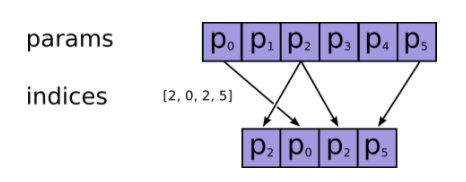

In [44]:
links = x['links']
print("links is a list of the links used along all src-dest paths - lenth: ",len(links),"\n",links[:10],"\n")


print("link state dimension is 32 x total number of links in the network - size (n_link,hid_dim) :",link_state.shape,"\n", link_state[:10,:10])

h_tild = tf.gather(link_state,links)
print("\n\nThe hidden link state after gathering selects all of the links used traversing all of the paths each time a link is used, and grabs that links hidden state")

print("H_tild shape: ", h_tild.shape)

links is a list of the links used along all src-dest paths - lenth:  390 
 [0, 1, 2, 2, 10, 1, 8, 2, 10, 14] 

link state dimension is 32 x total number of links in the network - size (n_link,hid_dim) : (42, 32) 
 tf.Tensor(
[[10000.     0.     0.     0.     0.     0.     0.     0.     0.     0.]
 [10000.     0.     0.     0.     0.     0.     0.     0.     0.     0.]
 [10000.     0.     0.     0.     0.     0.     0.     0.     0.     0.]
 [10000.     0.     0.     0.     0.     0.     0.     0.     0.     0.]
 [10000.     0.     0.     0.     0.     0.     0.     0.     0.     0.]
 [10000.     0.     0.     0.     0.     0.     0.     0.     0.     0.]
 [10000.     0.     0.     0.     0.     0.     0.     0.     0.     0.]
 [10000.     0.     0.     0.     0.     0.     0.     0.     0.     0.]
 [25000.     0.     0.     0.     0.     0.     0.     0.     0.     0.]
 [10000.     0.     0.     0.     0.     0.     0.     0.     0.     0.]], shape=(10, 10), dtype=float32)


The hidden

In [105]:
## Pytorch implementations
t_zero = torch.zeros(x['n_links'],32-1)
l_cap_expanded = torch.unsqueeze(torch.tensor(x['link_capacity'].numpy()),axis=1)
l_cap_expanded.shape,t_zero
link_h_state = torch.cat((l_cap_expanded,t_zero),axis=1)


indices = torch.zeros(len(links),32)
for i in range(len(links)):
    link_id = links[i]
    indices[i,:] = link_id

t_h = torch.gather(link_h_state,0,indices.long())


In [154]:
paths = x['paths']
seqs = x['sequences']


ids = tf.stack([paths, seqs], axis=1)
print(ids.shape)

# find the longest sequence routing path i.e. most hops for a src-dest pair
p_max = tf.reduce_max(paths)
max_len = tf.reduce_max(seqs) + 1 
print(max_len)


# matrix for the paths x max seq x path state dim
shape = tf.stack([
    x['n_paths'],
    max_len,
    int(config['HYPERPARAMETERS']['link_state_dim'])])

print(shape)

# ones_like makes a tensor the same shape of paths [1,1,1 ..... 1] - 390 length
# sum up over the the elements that share the same paths i.e [0,0,1,1,2,2,2] = [2,2,3]
# creates a list of path lengths
lens = tf.math.segment_sum(data=tf.ones_like(paths),
                                       segment_ids=paths)
print("length of lens: ",len(lens),lens.shape)


# Generate the aforementioned tensor [n_paths, max_len_path, dimension_link]
# [390 x 2], [390 x 32], [182,3,32]
# [indices], [updates], shape
# (path_id,seq_id) pair moves the hidden state vector to the path_id,seq_id element of link inputs, which is shape 'shape'
link_inputs = tf.scatter_nd(ids, h_tild, shape)
link_inputs[3,1].numpy()

(390, 2)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor([182   3  32], shape=(3,), dtype=int32)
length of lens:  182 (182,)


array([25000.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.],
      dtype=float32)

In [149]:
### Pytorch implementation
paths = torch.tensor(x['paths'])
seqs = torch.tensor(x['sequences'])
ids = torch.stack((paths,seqs),axis = 1)
ids.shape
scatter_src = torch.unsqueeze(torch.ones_like(paths),1)
print(scatter_src.shape)
lens = torch.zeros(x['n_paths'],1).long()
print(lens.shape)

lens = lens.scatter_add_(dim = 0, src = scatter_src,
                           index=torch.unsqueeze(paths,1))
lens.shape

print(ids.unsqueeze(2).shape)

# pytorch equivalent of scatter_nd -> index_add
path_rnn_input = torch.zeros((x['n_paths'],3,32))
for i in range(ids.shape[0]):
    p_ind = ids[i,0]
    s_ind = ids[i,1]
    path_rnn_input[p_ind,s_ind,:] = t_h[i]


path_rnn_input[3,1]


torch.Size([390, 1])
torch.Size([182, 1])
torch.Size([390, 2, 1])


tensor([25000.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.])

In [193]:
### testing the link update aggregation
Path_RNN_Hidden_States = torch.ones((182,3,32))
link_messages = torch.zeros((len(links),32))
for i in range(ids.shape[0]):
    p_ind = int(ids[i,0])
    s_ind = int(ids[i,1])
    link_messages[i] = Path_RNN_Hidden_States[p_ind,s_ind,:]

# aggregate the messages
# aggregated link message is size (n_links x link state dim)
# aggregated along rows based on link index in the links vector
aggregated_link_message = torch.zeros((x['n_links'],32))
_ = aggregated_link_message.scatter_add_(0,torch.tensor(links).unsqueeze(1),link_messages)

In [194]:
aggregated_link_message

tensor([[ 5.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 6.,  0.,  0.,  ...,  0.,  0.,  0.],
        [12.,  0.,  0.,  ...,  0.,  0.,  0.],
        ...,
        [ 4.,  0.,  0.,  ...,  0.,  0.,  0.],
        [10.,  0.,  0.,  ...,  0.,  0.,  0.],
        [11.,  0.,  0.,  ...,  0.,  0.,  0.]])

In [177]:
print(int(ids[0,0]))

0


#### The path updating RNN outputs the entire hidden state sequences, which are the messages from the path that are used to update the links. These messages from the paths are aggregated for each link and then the link runs through an RNN


In [ ]:
# For every link, gather and sum the sequence of hidden states of the paths that contain it
                #(182,32) (390,2)
m = tf.gather_nd(outputs, ids)
m = tf.math.unsorted_segment_sum(m, links, f_['n_links'])


In [163]:

class RouteNetModel(tf.keras.Model):
    """ Init method for the custom model.

    Args:
        config (dict): Python dictionary containing the diferent configurations
                       and hyperparameters.
        output_units (int): Output units for the last readout's layer.

    Attributes:
        config (dict): Python dictionary containing the diferent configurations
                       and hyperparameters.
        link_update (GRUCell): Link GRU Cell used in the Message Passing step.
        path_update (GRUCell): Path GRU Cell used in the Message Passing step.
        readout (Keras Model): Readout Neural Network. It expects as input the
                               path states and outputs the per-path delay.
    """

    def __init__(self, config, output_units=1):
        super(RouteNetModel, self).__init__()

        # Configuration dictionary. It contains the needed Hyperparameters for the model.
        # All the Hyperparameters can be found in the config.ini file
        self.config = config

        # GRU Cells used in the Message Passing step
        self.link_update = tf.keras.layers.GRUCell(int(self.config['HYPERPARAMETERS']['link_state_dim']))
        self.path_update = tf.keras.layers.GRUCell(int(self.config['HYPERPARAMETERS']['path_state_dim']))

        # Readout Neural Network. It expects as input the path states and outputs the per-path delay
        self.readout = tf.keras.Sequential([
            tf.keras.layers.Input(shape=int(self.config['HYPERPARAMETERS']['path_state_dim'])),
            tf.keras.layers.Dense(int(self.config['HYPERPARAMETERS']['readout_units']),
                                  activation=tf.nn.selu,
                                  kernel_regularizer=tf.keras.regularizers.l2(
                                      float(self.config['HYPERPARAMETERS']['l2'])),
                                  ),
            tf.keras.layers.Dense(int(self.config['HYPERPARAMETERS']['readout_units']),
                                  activation=tf.nn.relu,
                                  kernel_regularizer=tf.keras.regularizers.l2(
                                      float(self.config['HYPERPARAMETERS']['l2']))),
            tf.keras.layers.Dense(output_units,
                                  kernel_regularizer=tf.keras.regularizers.l2(
                                      float(self.config['HYPERPARAMETERS']['l2_2'])))
                                            ])
        
    def call(self, inputs, training=False):
        """This function is execution each time the model is called

        Args:
            inputs (dict): Features used to make the predictions.
            training (bool): Whether the model is training or not. If False, the
                             model does not update the weights.

        Returns:
            tensor: A tensor containing the per-path delay.
        """

        f_ = inputs

        links = f_['links']                  # (1 x sum of the links along all the paths)          
        paths = f_['paths']                  # (1 x sum of the links along all the paths)
        seqs = f_['sequences']               # (1 x sum of the links along all the paths)

        # Compute the shape for the  all-zero tensor for link_state
        # shape
        shape = tf.stack([
            f_['n_links'],
            int(self.config['HYPERPARAMETERS']['link_state_dim']) - 1
        ], axis=0)

        # Initialize the initial hidden state for links
        link_state = tf.concat([
            tf.expand_dims(f_['link_capacity'], axis=1),
            tf.zeros(shape)
        ], axis=1)

        # Compute the shape for the  all-zero tensor for path_state
        shape = tf.stack([
            f_['n_paths'],
            int(self.config['HYPERPARAMETERS']['path_state_dim']) - 1
        ], axis=0)

        # Initialize the initial hidden state for paths
        path_state = tf.concat([
            tf.expand_dims(f_['bandwith'], axis=1),
            tf.zeros(shape)
        ], axis=1)

        # Iterate t times doing the message passing
        for _ in range(int(self.config['HYPERPARAMETERS']['t'])):

            # The following lines generate a tensor of dimensions [n_paths, max_len_path, dimension_link] with all 0
            # but the link hidden states
            h_tild = tf.gather(link_state, links)

            #(182,3,32) 182 paths by max link length 3 x (hidden dim of links)
            ids = tf.stack([paths, seqs], axis=1)
            max_len = tf.reduce_max(seqs) + 1
            shape = tf.stack([
                f_['n_paths'],
                max_len,
                int(self.config['HYPERPARAMETERS']['link_state_dim'])])

            # consolidates the path list to a list of len per path (182,1)
            lens = tf.math.segment_sum(data=tf.ones_like(paths),
                                       segment_ids=paths)

            # Generate the aforementioned tensor [n_paths, max_len_path, dimension_link]
            # maps the 
            link_inputs = tf.scatter_nd(ids, h_tild, shape)

            # Define the RNN used for the message passing links to paths
            gru_rnn = tf.keras.layers.RNN(self.path_update,
                                          return_sequences=True,
                                          return_state=True)

            # First message passing: update the path_state
            outputs, path_state = gru_rnn(inputs=link_inputs,
                                          initial_state=path_state,
                                          mask=tf.sequence_mask(lens))
            print(outputs.shape,path_state.shape)

            # For every link, gather and sum the sequence of hidden states of the paths that contain it
            m = tf.gather_nd(outputs, ids)
            print(m.shape)
            m = tf.math.unsorted_segment_sum(m, links, f_['n_links'])

            # Second message passing: update the link_state
            # single sequence RNN
            link_state, _ = self.link_update(m, [link_state])

        # Call the readout ANN and return its predictions
        r = self.readout(path_state, training=training)

        return r

In [164]:
model = RouteNetModel(config)

In [165]:
model.call(x)

(182, 3, 32) (182, 32)
(390, 32)
(182, 3, 32) (182, 32)
(390, 32)
(182, 3, 32) (182, 32)
(390, 32)
(182, 3, 32) (182, 32)
(390, 32)
(182, 3, 32) (182, 32)
(390, 32)
(182, 3, 32) (182, 32)
(390, 32)
(182, 3, 32) (182, 32)
(390, 32)
(182, 3, 32) (182, 32)
(390, 32)


<tf.Tensor: shape=(182, 1), dtype=float32, numpy=
array([[44.879337 ],
       [13.564499 ],
       [32.82257  ],
       [63.465187 ],
       [75.84155  ],
       [47.759644 ],
       [30.451538 ],
       [32.81943  ],
       [18.351482 ],
       [13.085636 ],
       [44.243713 ],
       [64.99513  ],
       [32.394806 ],
       [20.360905 ],
       [ 9.794849 ],
       [14.984617 ],
       [65.53087  ],
       [79.69016  ],
       [24.111595 ],
       [19.991581 ],
       [51.65772  ],
       [16.426754 ],
       [38.732372 ],
       [16.533348 ],
       [18.48492  ],
       [55.664658 ],
       [24.039871 ],
       [72.943115 ],
       [ 9.218047 ],
       [23.818947 ],
       [14.042505 ],
       [38.31169  ],
       [37.345036 ],
       [70.50936  ],
       [22.27504  ],
       [80.99699  ],
       [25.549118 ],
       [35.28588  ],
       [ 9.058372 ],
       [15.0028   ],
       [72.87516  ],
       [26.749939 ],
       [22.541492 ],
       [50.80774  ],
       [64.17939  ],
     